# Machine Learning Discussion Meeting - Interactive Notebook

In this notebook, we will implement some of the various techniques discussed in the talk "Machine Learning: Concepts and Application".

To install the requirements, please follow the instructions in the readme.

This notebook is composed of 4 parts:

1. We will build a deep convolutional neural network to classify handwritten digits.

2. Next, we will build a deep convolutional autoencoder to build a compression algorithm for the handwritten digits.

3. We will use a previously generated dataset to train a deep learning model to solve the Schrodinger Equation and build the total energy as a functional of the external potential for one-electron model systems. 

4. Finally, the same model will be used to build the total energy as a functional of the density to compare with part 3.

 ## 1. Deep Convolutional Neural Network to Classify Handwritten Digits.

In [1]:
# Imports.
import pickle
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt


# Set up GPU.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


# Load in the dataset.
dataset = tf.keras.datasets.mnist


# Split the dataset into training, validation and testing data.
(x_train, y_train), (x_test, y_test) = dataset.load_data()
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_validation = x_test[:5000,...]
x_test = x_test[5000:,...]
y_validation = y_test[:5000,...]
y_test = y_test[5000:,...]


#  Convert the y values to categorical.
y_train = tf.keras.utils.to_categorical(y_train)
y_validation = tf.keras.utils.to_categorical(y_validation)
y_test = tf.keras.utils.to_categorical(y_test)


# Normalise the data.
x_train = x_train / 255.0
x_validation = x_validation / 255.0
x_test = x_test / 255.0


# Print the shapes of the data
print(x_train.shape, x_validation.shape, x_test.shape, y_train.shape, y_validation.shape, y_test.shape)

(60000, 28, 28, 1) (5000, 28, 28, 1) (5000, 28, 28, 1) (60000, 10) (5000, 10) (5000, 10)


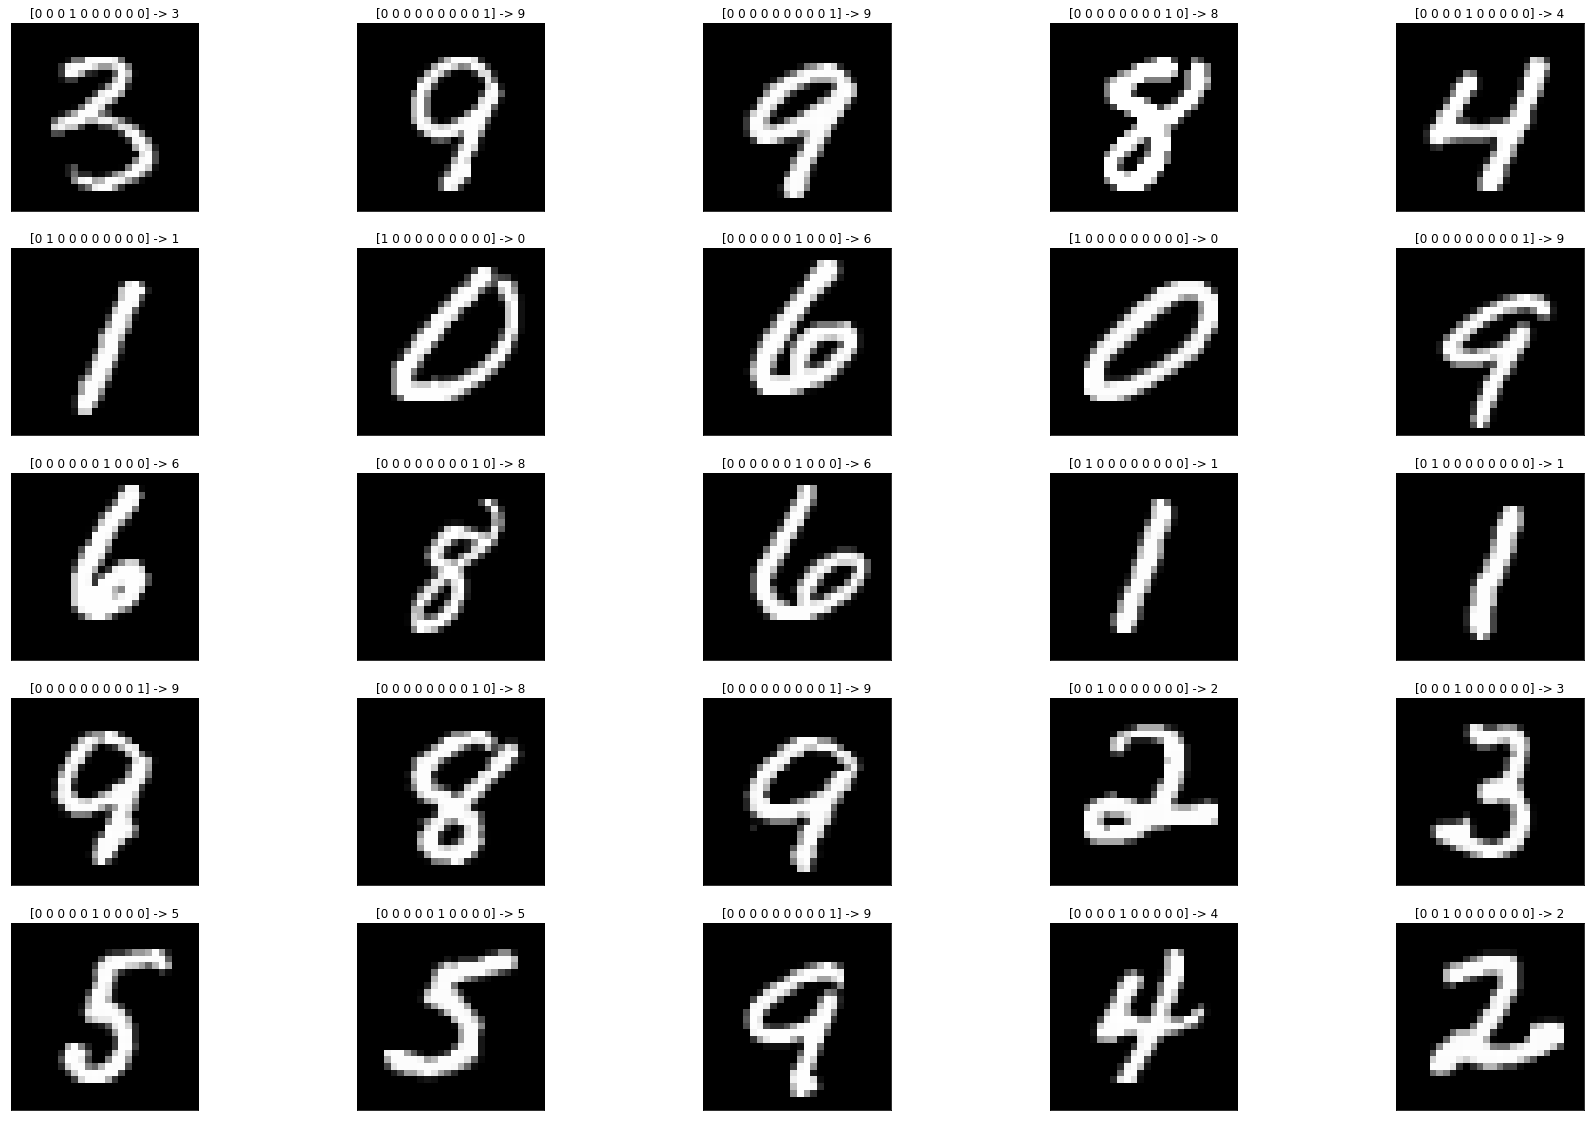

In [2]:
# Plot some results.
plt.rcParams['figure.figsize'] = [30, 20]
fig, axs = plt.subplots(5, 5)
k = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].imshow(x_test[k, :, :, :].reshape((28, 28)), cmap='gray')
        axs[i, j].set_title('{0} -> {1}'.format(y_test[k].astype(int), y_test[k].argmax()))
        axs[i, j].set_yticklabels([])
        axs[i, j].set_xticklabels([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        k = k + 1
plt.savefig('digits.pdf')

In [3]:
# Build the neural network.
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=84, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))


# Complile the model.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [4]:
# Train the model.
training = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=5, batch_size=250, shuffle=True)

Epoch 1/5
240/240 [==============================] - 3s 4ms/step - loss: 0.4214 - accuracy: 0.8818 - val_loss: 0.1370 - val_accuracy: 0.9566
Epoch 2/5
240/240 [==============================] - 1s 3ms/step - loss: 0.0964 - accuracy: 0.9705 - val_loss: 0.0916 - val_accuracy: 0.9710
Epoch 3/5
240/240 [==============================] - 1s 3ms/step - loss: 0.0692 - accuracy: 0.9787 - val_loss: 0.0825 - val_accuracy: 0.9736
Epoch 4/5
240/240 [==============================] - 1s 4ms/step - loss: 0.0572 - accuracy: 0.9828 - val_loss: 0.0886 - val_accuracy: 0.9726
Epoch 5/5
240/240 [==============================] - 1s 4ms/step - loss: 0.0457 - accuracy: 0.9860 - val_loss: 0.0608 - val_accuracy: 0.9816


In [5]:
# Evaluate the model.
model.evaluate(x_test, y_test, verbose=2)

157/157 - 1s - loss: 0.0188 - accuracy: 0.9942 - 766ms/epoch - 5ms/step


[0.018795309588313103, 0.9941999912261963]

In [6]:
# Predict using the model.
N = 25 # Number of test images to predict
y_pred = model.predict(x_test[:N, :, :])

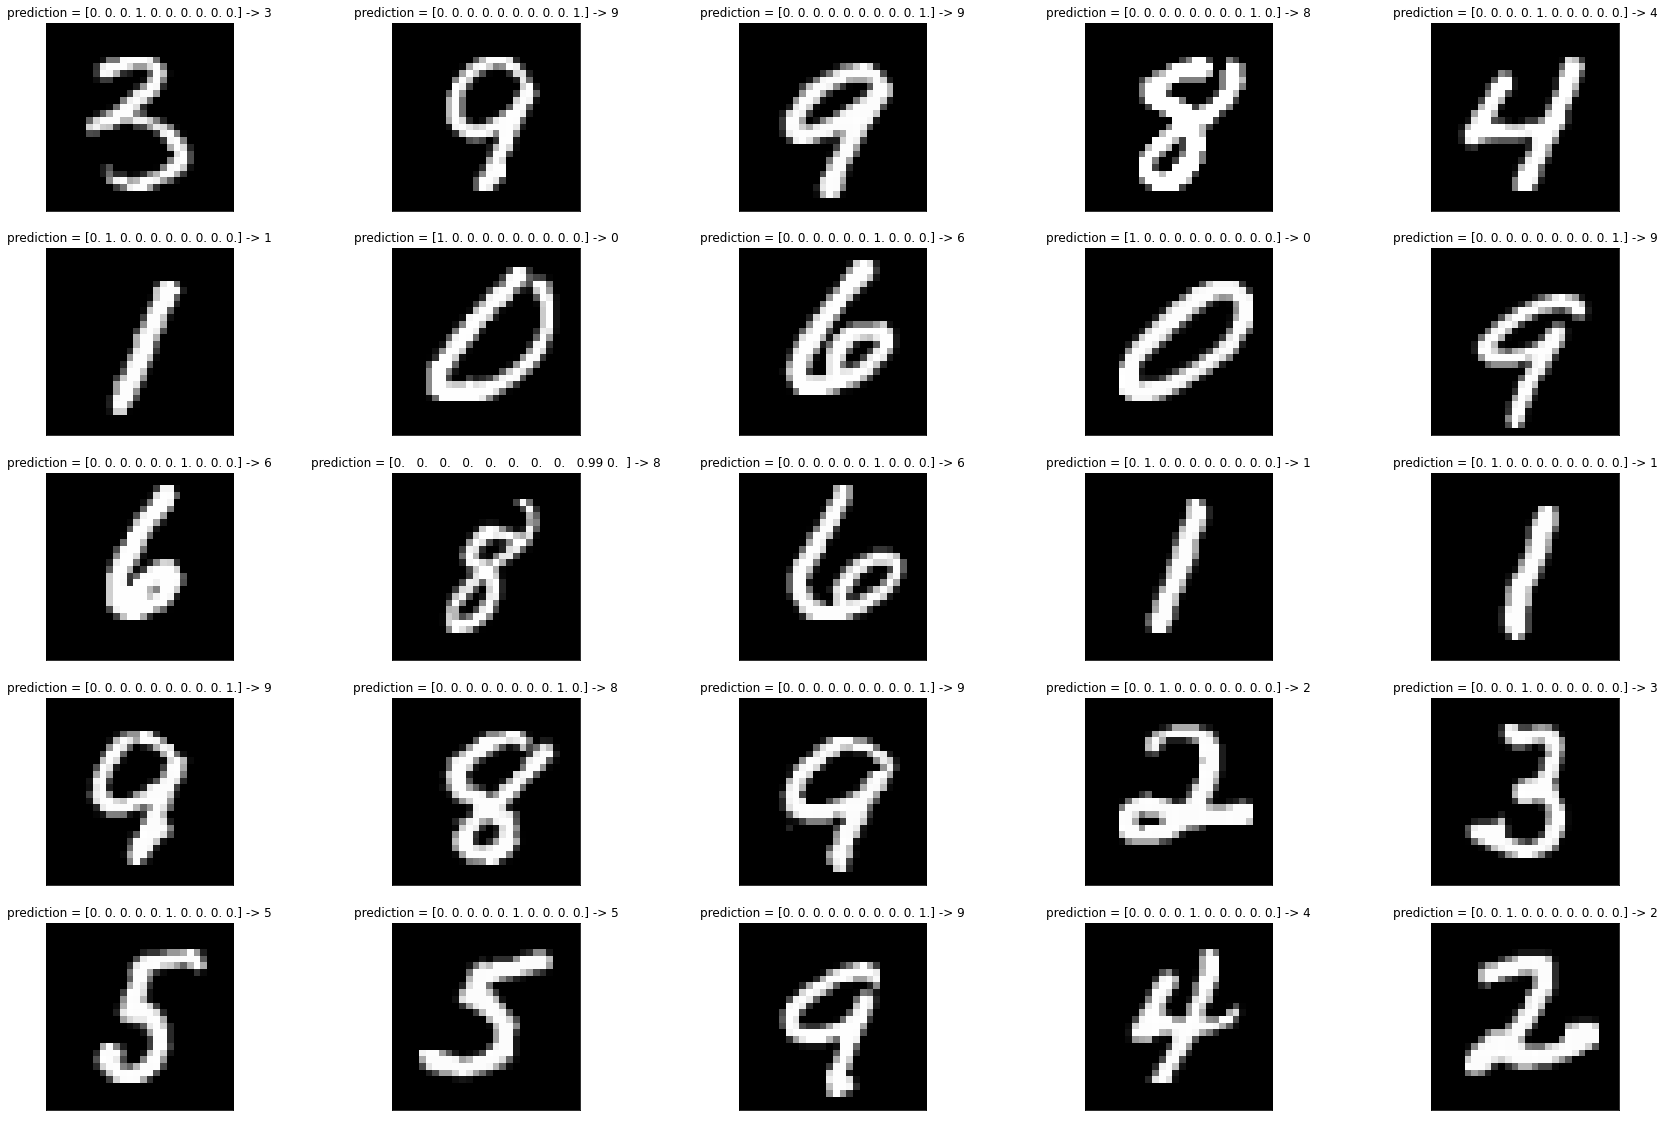

In [7]:
# Plot some results.
plt.rcParams['figure.figsize'] = [30, 20]
fig, axs = plt.subplots(5, 5)
k = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].imshow(x_test[k, :, :, :].reshape((28, 28)), cmap='gray')
        axs[i, j].set_title('prediction = {0} -> {1}'.format(y_pred[k].round(2), y_pred[k].argmax()))
        axs[i, j].set_yticklabels([])
        axs[i, j].set_xticklabels([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        k = k + 1
plt.savefig('predictions.pdf')

In [8]:
# Hyperparameters
optimizer = 'adadelta'
learning_rate = 1.0
epochs = 30
batch_size = 128
loss = 'mse'
shuffle = True


# Build the model.
input_img = tf.keras.layers.Input(shape=(28, 28, 1))
encoded = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = tf.keras.layers.Conv2D(2, (3, 3), activation='relu', padding='same')(encoded)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
latent_shape = (int(encoded.shape[1]), int(encoded.shape[2]), int(encoded.shape[3]))
print(latent_shape)
decoded = tf.keras.layers.Conv2D(2, (3, 3), activation='relu', padding='same')(encoded)
decoded = tf.keras.layers.UpSampling2D((2, 2))(decoded)
decoded = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(decoded)
decoded = tf.keras.layers.UpSampling2D((2, 2))(decoded)
decoded = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(decoded)
decoded = tf.keras.layers.UpSampling2D((2, 2))(decoded)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)
autoencoder = tf.keras.models.Model(input_img, decoded)


# Print the model architecture.
autoencoder.summary()


# Define the encoder.
encoder = tf.keras.models.Model(input_img, encoded)


# Define the decoder.
encoded_input = tf.keras.layers.Input(shape=latent_shape)
decoder_layers = len(autoencoder.layers) - len(encoder.layers)
for i in range(decoder_layers, 0, -1):
    decoder_layer = autoencoder.layers[-i]
    if i == decoder_layers:
        nest = decoder_layer(encoded_input)
    else:
        nest = decoder_layer(nest)
decoder = tf.keras.models.Model(encoded_input, nest)


# Compile the autoencoder.
if optimizer == 'adam':
    opt = tf.keras.optimizers.Adam(lr=learning_rate)
if optimizer == 'sgd':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.1)
if optimizer == 'adadelta':
    opt = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
autoencoder.compile(optimizer=opt, loss=loss)
latent_shape = tuple(encoder.layers[-1].output_shape[1:4])

(4, 4, 2)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 2)       

In [9]:
# Train the autoencoder.
training = autoencoder.fit(x_train, x_train, validation_data=(x_validation, x_validation), epochs=epochs, batch_size=batch_size, shuffle=shuffle)

Epoch 1/30
469/469 [==============================] - 5s 7ms/step - loss: 0.0639 - val_loss: 0.0474
Epoch 2/30
469/469 [==============================] - 3s 5ms/step - loss: 0.0447 - val_loss: 0.0389
Epoch 3/30
469/469 [==============================] - 3s 5ms/step - loss: 0.0390 - val_loss: 0.0367
Epoch 4/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0361 - val_loss: 0.0349
Epoch 5/30
469/469 [==============================] - 3s 5ms/step - loss: 0.0340 - val_loss: 0.0315
Epoch 6/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0325 - val_loss: 0.0312
Epoch 7/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0313 - val_loss: 0.0304
Epoch 8/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0301 - val_loss: 0.0297
Epoch 9/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0291 - val_loss: 0.0278
Epoch 10/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0283 - val_loss: 0.0279

In [10]:
# Encode and then decode some test data.
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

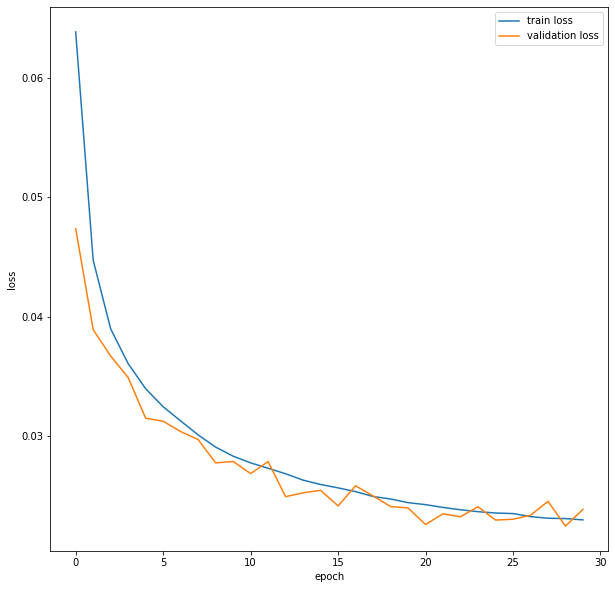

In [11]:
# plotting the training
train_loss = np.array(training.history['loss'])
test_loss = np.array(training.history['val_loss'])
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('training.pdf')

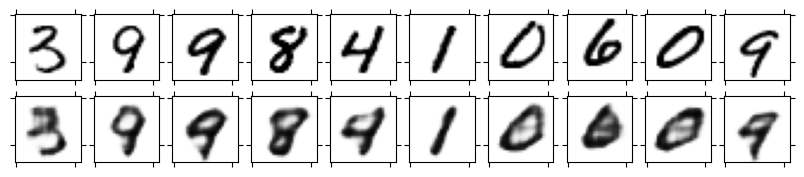

In [12]:
# Plot the decoded test data.
n = 10
vmax = np.max(np.abs(x_test))
vmin = -np.max(np.abs(x_test))
plt.figure(figsize=(10, 2), dpi=100)
for i in range(10):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i,:,:,0], norm=plt.Normalize(0,vmax), cmap=matplotlib.cm.binary, interpolation='hamming')
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_imgs[i,:,:,0], norm=plt.Normalize(0,vmax), cmap=matplotlib.cm.binary, interpolation='hamming')
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.savefig('auto_predictions.pdf')

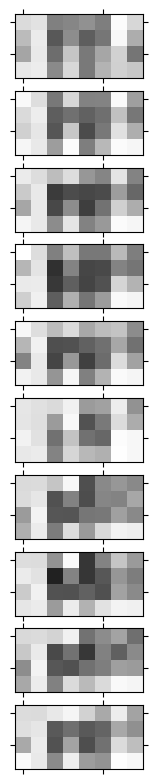

In [13]:
# Plot the latent spaces.
n = 10
vmax = np.max(np.abs(encoded_imgs))
vmin = -np.max(np.abs(encoded_imgs))
plt.figure(figsize=(10, 10), dpi=100)
for i in range(10):
    ax = plt.subplot(n, 1, i + 1)
    plt.imshow(np.reshape(encoded_imgs[i,:,:,:],(latent_shape[0],latent_shape[1]*latent_shape[2])), norm=plt.Normalize(0,vmax), cmap=matplotlib.cm.binary)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.savefig('latent.pdf')

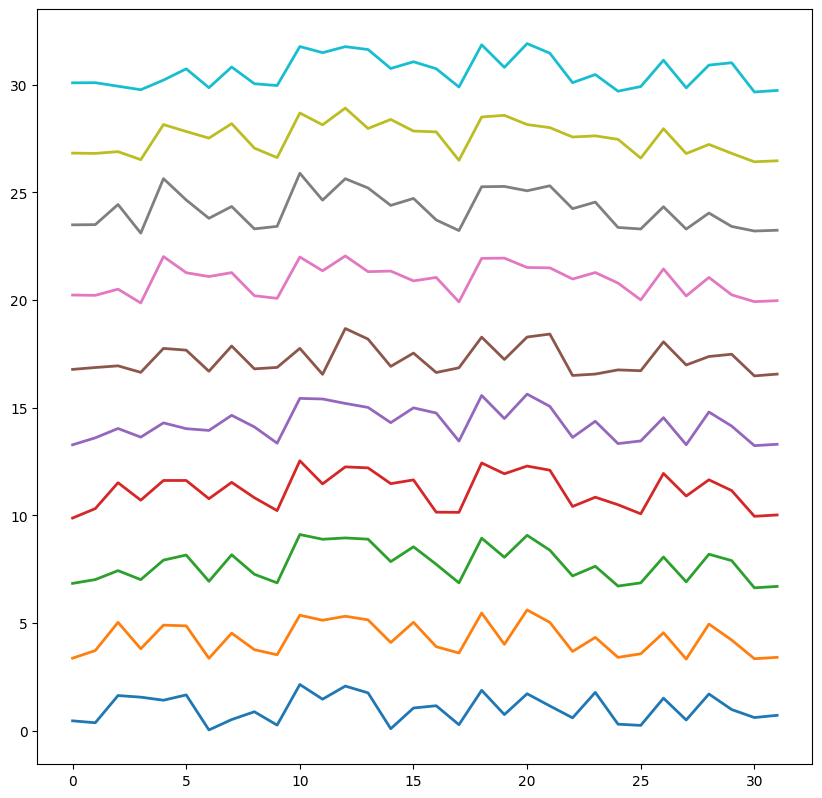

In [14]:
# Plot the flat latent spaces.
n = 10
shift = np.max(encoded_imgs)
plt.figure(figsize=(10, 10), dpi=100)
for i in range(10):
    plt.plot(np.reshape(encoded_imgs[i,:,:,:],(latent_shape[0]*latent_shape[1]*latent_shape[2]))+i*shift, label='${0}$'.format(i), linewidth=2.0)
plt.savefig('latent_flat.pdf')

In [15]:
# Load in the dataset.
V = pickle.load(open('V.db','rb'))
n = pickle.load(open('density.db','rb'))
E = pickle.load(open('E.db','rb'))


# Split the dataset into training, validation and testing data.
V = V.reshape(V.shape + (1,))
n = n.reshape(n.shape + (1,))
E = E.reshape(E.shape + (1,))
V_train = V[:50000,...]
V_validation = V[50000:75000,...]
V_test = V[75000:,...]
n_train = n[:50000,...]
n_validation = n[50000:75000,...]
n_test = n[75000:,...]
E_train = E[:50000,...]
E_validation = E[50000:75000,...]
E_test = E[75000:,...]
print(V.shape, n.shape, E.shape)


# Build the neural network.
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=(3), activation='tanh', input_shape=(64, 1)))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=(3), activation='tanh'))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=120, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=50, activation='tanh'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))


# Complile the model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')


# Train the model.
training = model.fit(V_train, E_train, validation_data=(V_validation, E_validation), epochs=50, batch_size=250, shuffle=True)


# Evaluate the model.
model.evaluate(V_test, E_test, verbose=2)


# Predict using the model.
N = 25 # Number of test images to predict
E_pred = model.predict(V_test[:N, :, :])

(100000, 64, 1) (100000, 64, 1) (100000, 1)
Epoch 1/50
200/200 [==============================] - 2s 4ms/step - loss: 0.1263 - val_loss: 0.0097
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0375 - val_loss: 0.0067
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0233 - val_loss: 0.0058
Epoch 4/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0189 - val_loss: 0.0048
Epoch 5/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0168 - val_loss: 0.0046
Epoch 6/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0152 - val_loss: 0.0036
Epoch 7/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0143 - val_loss: 0.0033
Epoch 8/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0134 - val_loss: 0.0033
Epoch 9/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0127 - val_loss: 0.0029
Epoch 10/50
200/200 [==============================] - 1

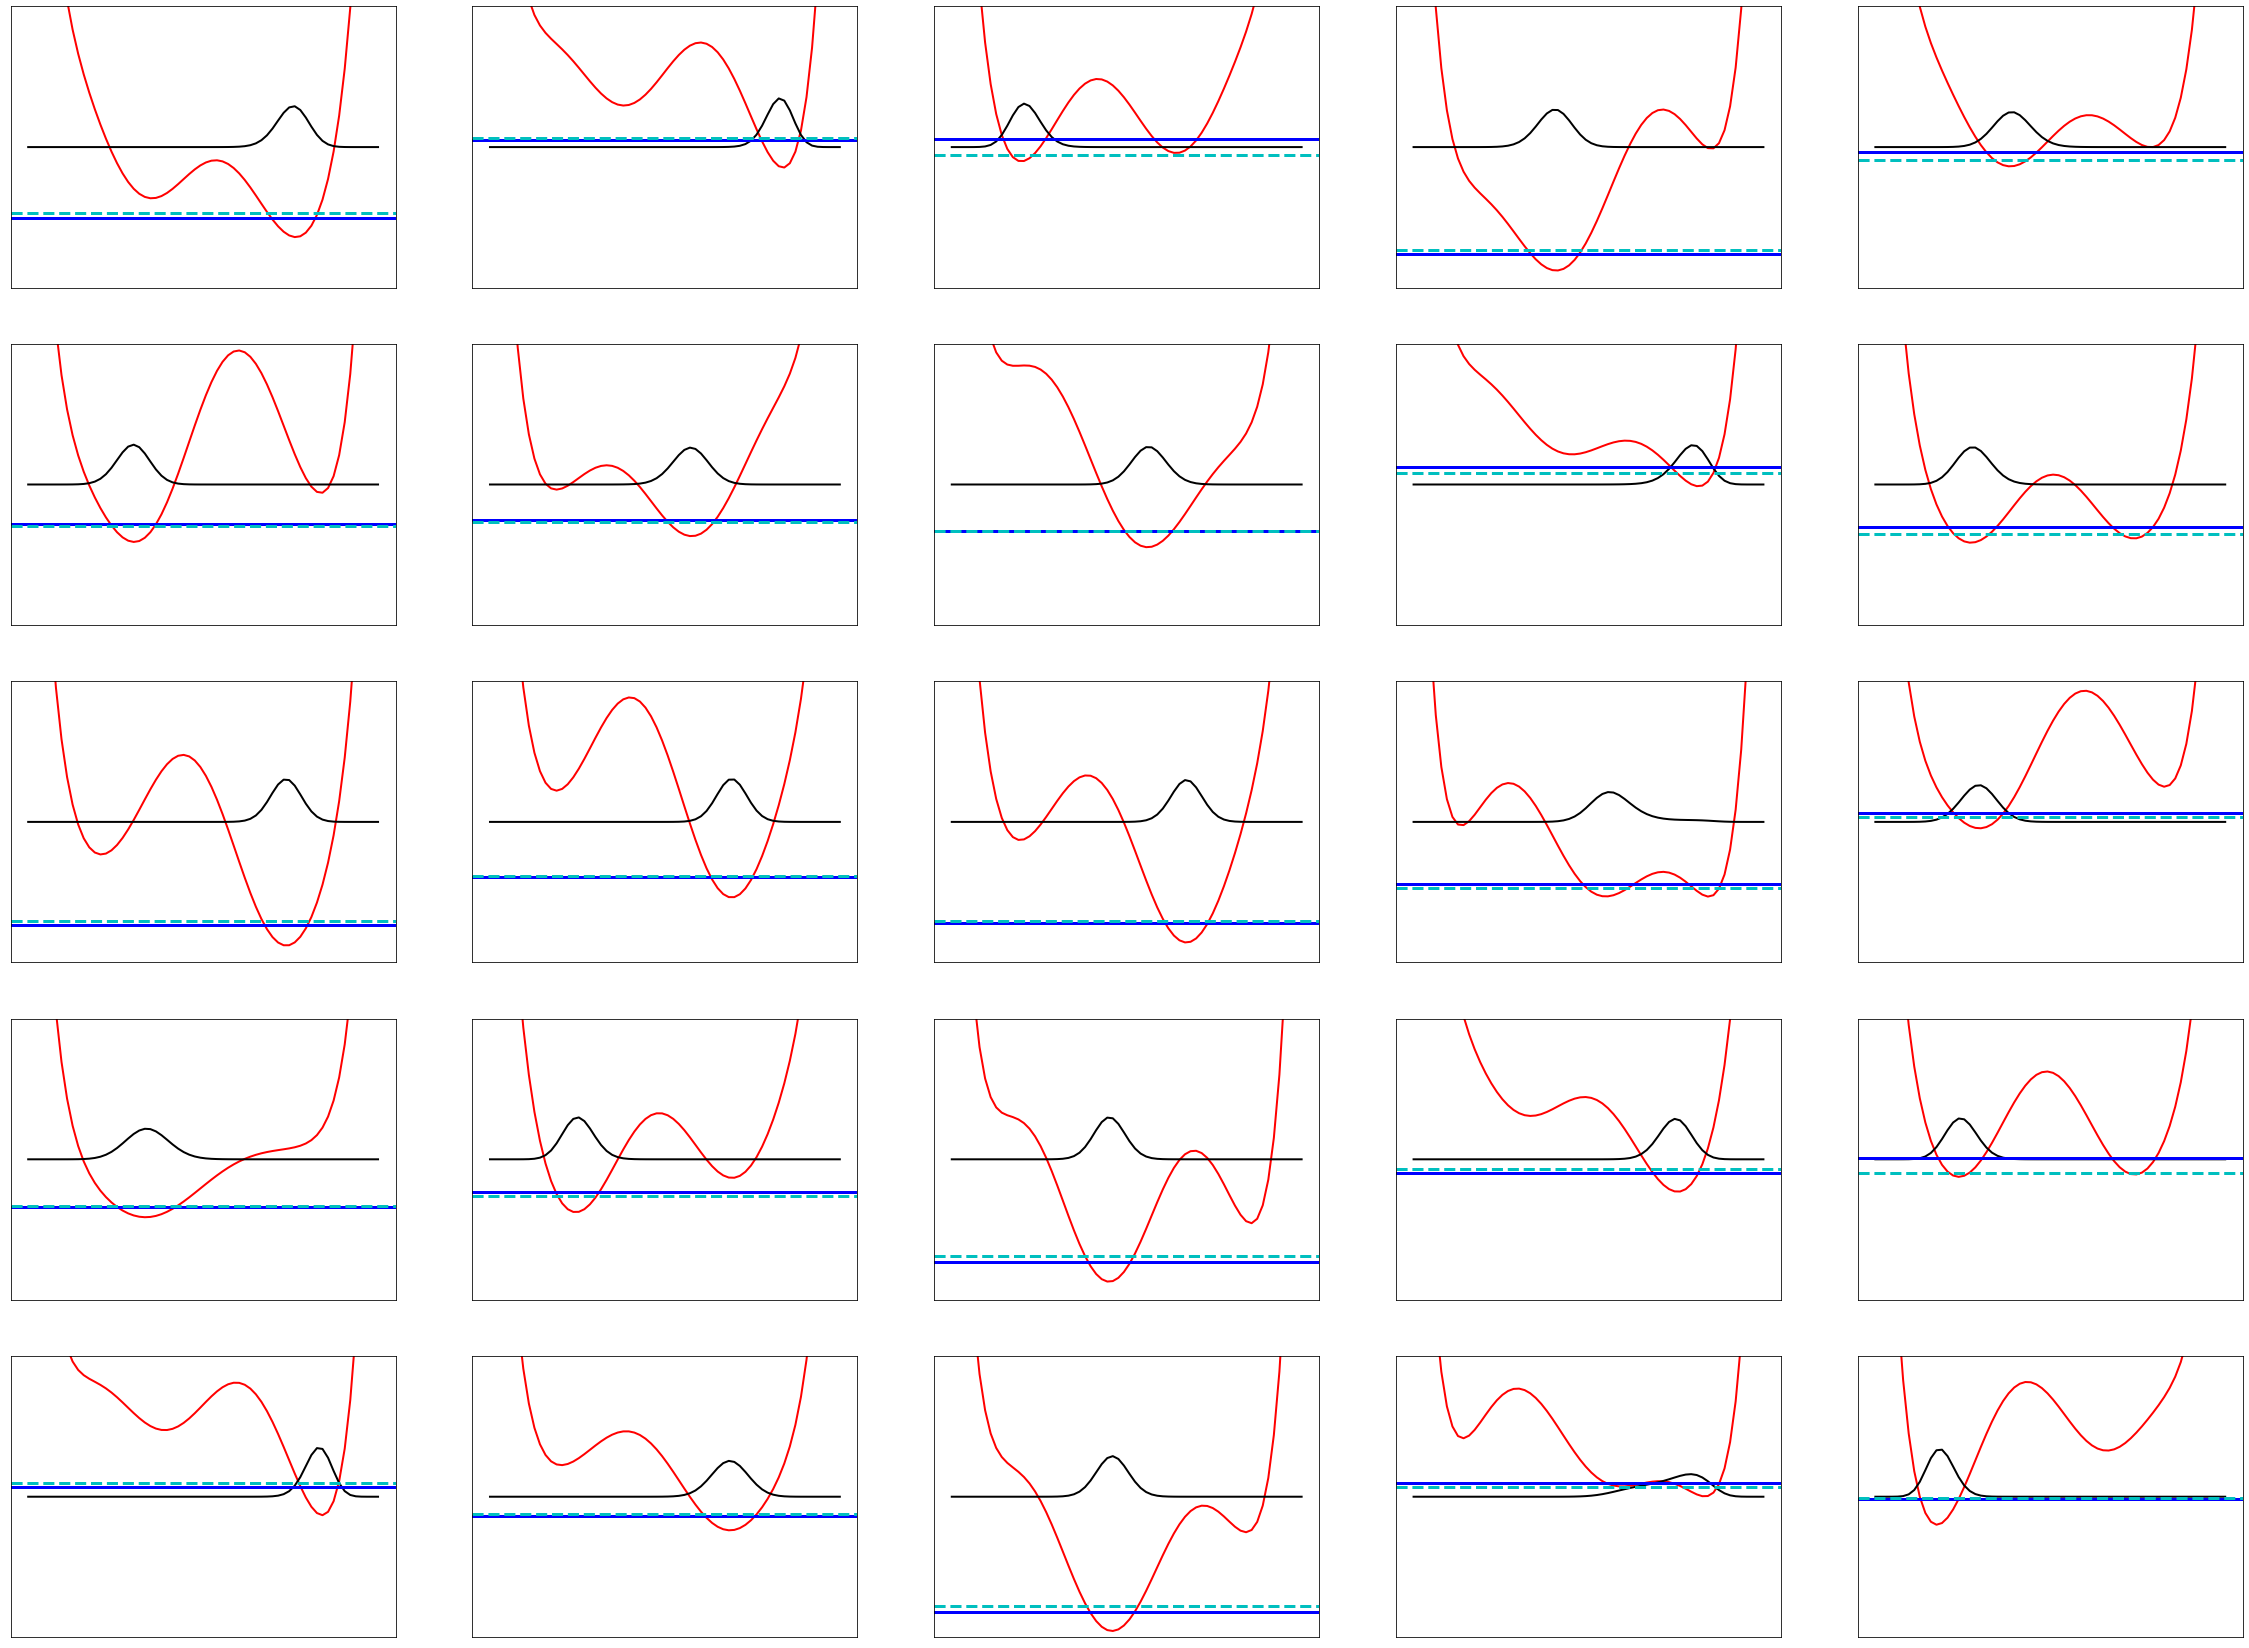

In [16]:
# Plot some results.
plt.rcParams['figure.figsize'] = [40, 30]
fig, axs = plt.subplots(5, 5)
k = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].plot(V_test[k, :, :].reshape(64,), 'r-', linewidth=2.0)
        axs[i, j].plot(n_test[k, :, :].reshape(64,), 'k-', linewidth=2.0)
        axs[i, j].axhline(E_test[k, 0], color='b', linewidth=3.0)
        axs[i, j].axhline(E_pred[k, 0], color='c', linestyle='--', linewidth=3.0)
        axs[i, j].set_ylim([-1,1])
        axs[i, j].set_yticklabels([])
        axs[i, j].set_xticklabels([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        k = k + 1
plt.savefig('v_predictions.pdf')

In [17]:
# Build the neural network.
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=(3), activation="tanh", input_shape=(64, 1)))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=(3), activation="tanh"))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=120, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=50, activation="tanh"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=1, activation="linear"))


# Complile the model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse")


# Train the model.
training = model.fit(n_train, E_train, validation_data=(n_validation, E_validation), epochs=50, batch_size=250, shuffle=True)


# Evaluate the model.
model.evaluate(n_test, E_test, verbose=2)


# Predict using the model.
N = 25 # Number of test images to predict
E_pred = model.predict(n_test[:N, :, :])

Epoch 1/50
200/200 [==============================] - 1s 4ms/step - loss: 0.1025 - val_loss: 0.0783
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0851 - val_loss: 0.0772
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0819 - val_loss: 0.0760
Epoch 4/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0801 - val_loss: 0.0750
Epoch 5/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0781 - val_loss: 0.0739
Epoch 6/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0768 - val_loss: 0.0730
Epoch 7/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0757 - val_loss: 0.0719
Epoch 8/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0746 - val_loss: 0.0715
Epoch 9/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0738 - val_loss: 0.0701
Epoch 10/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0728 - val_loss: 0.0693

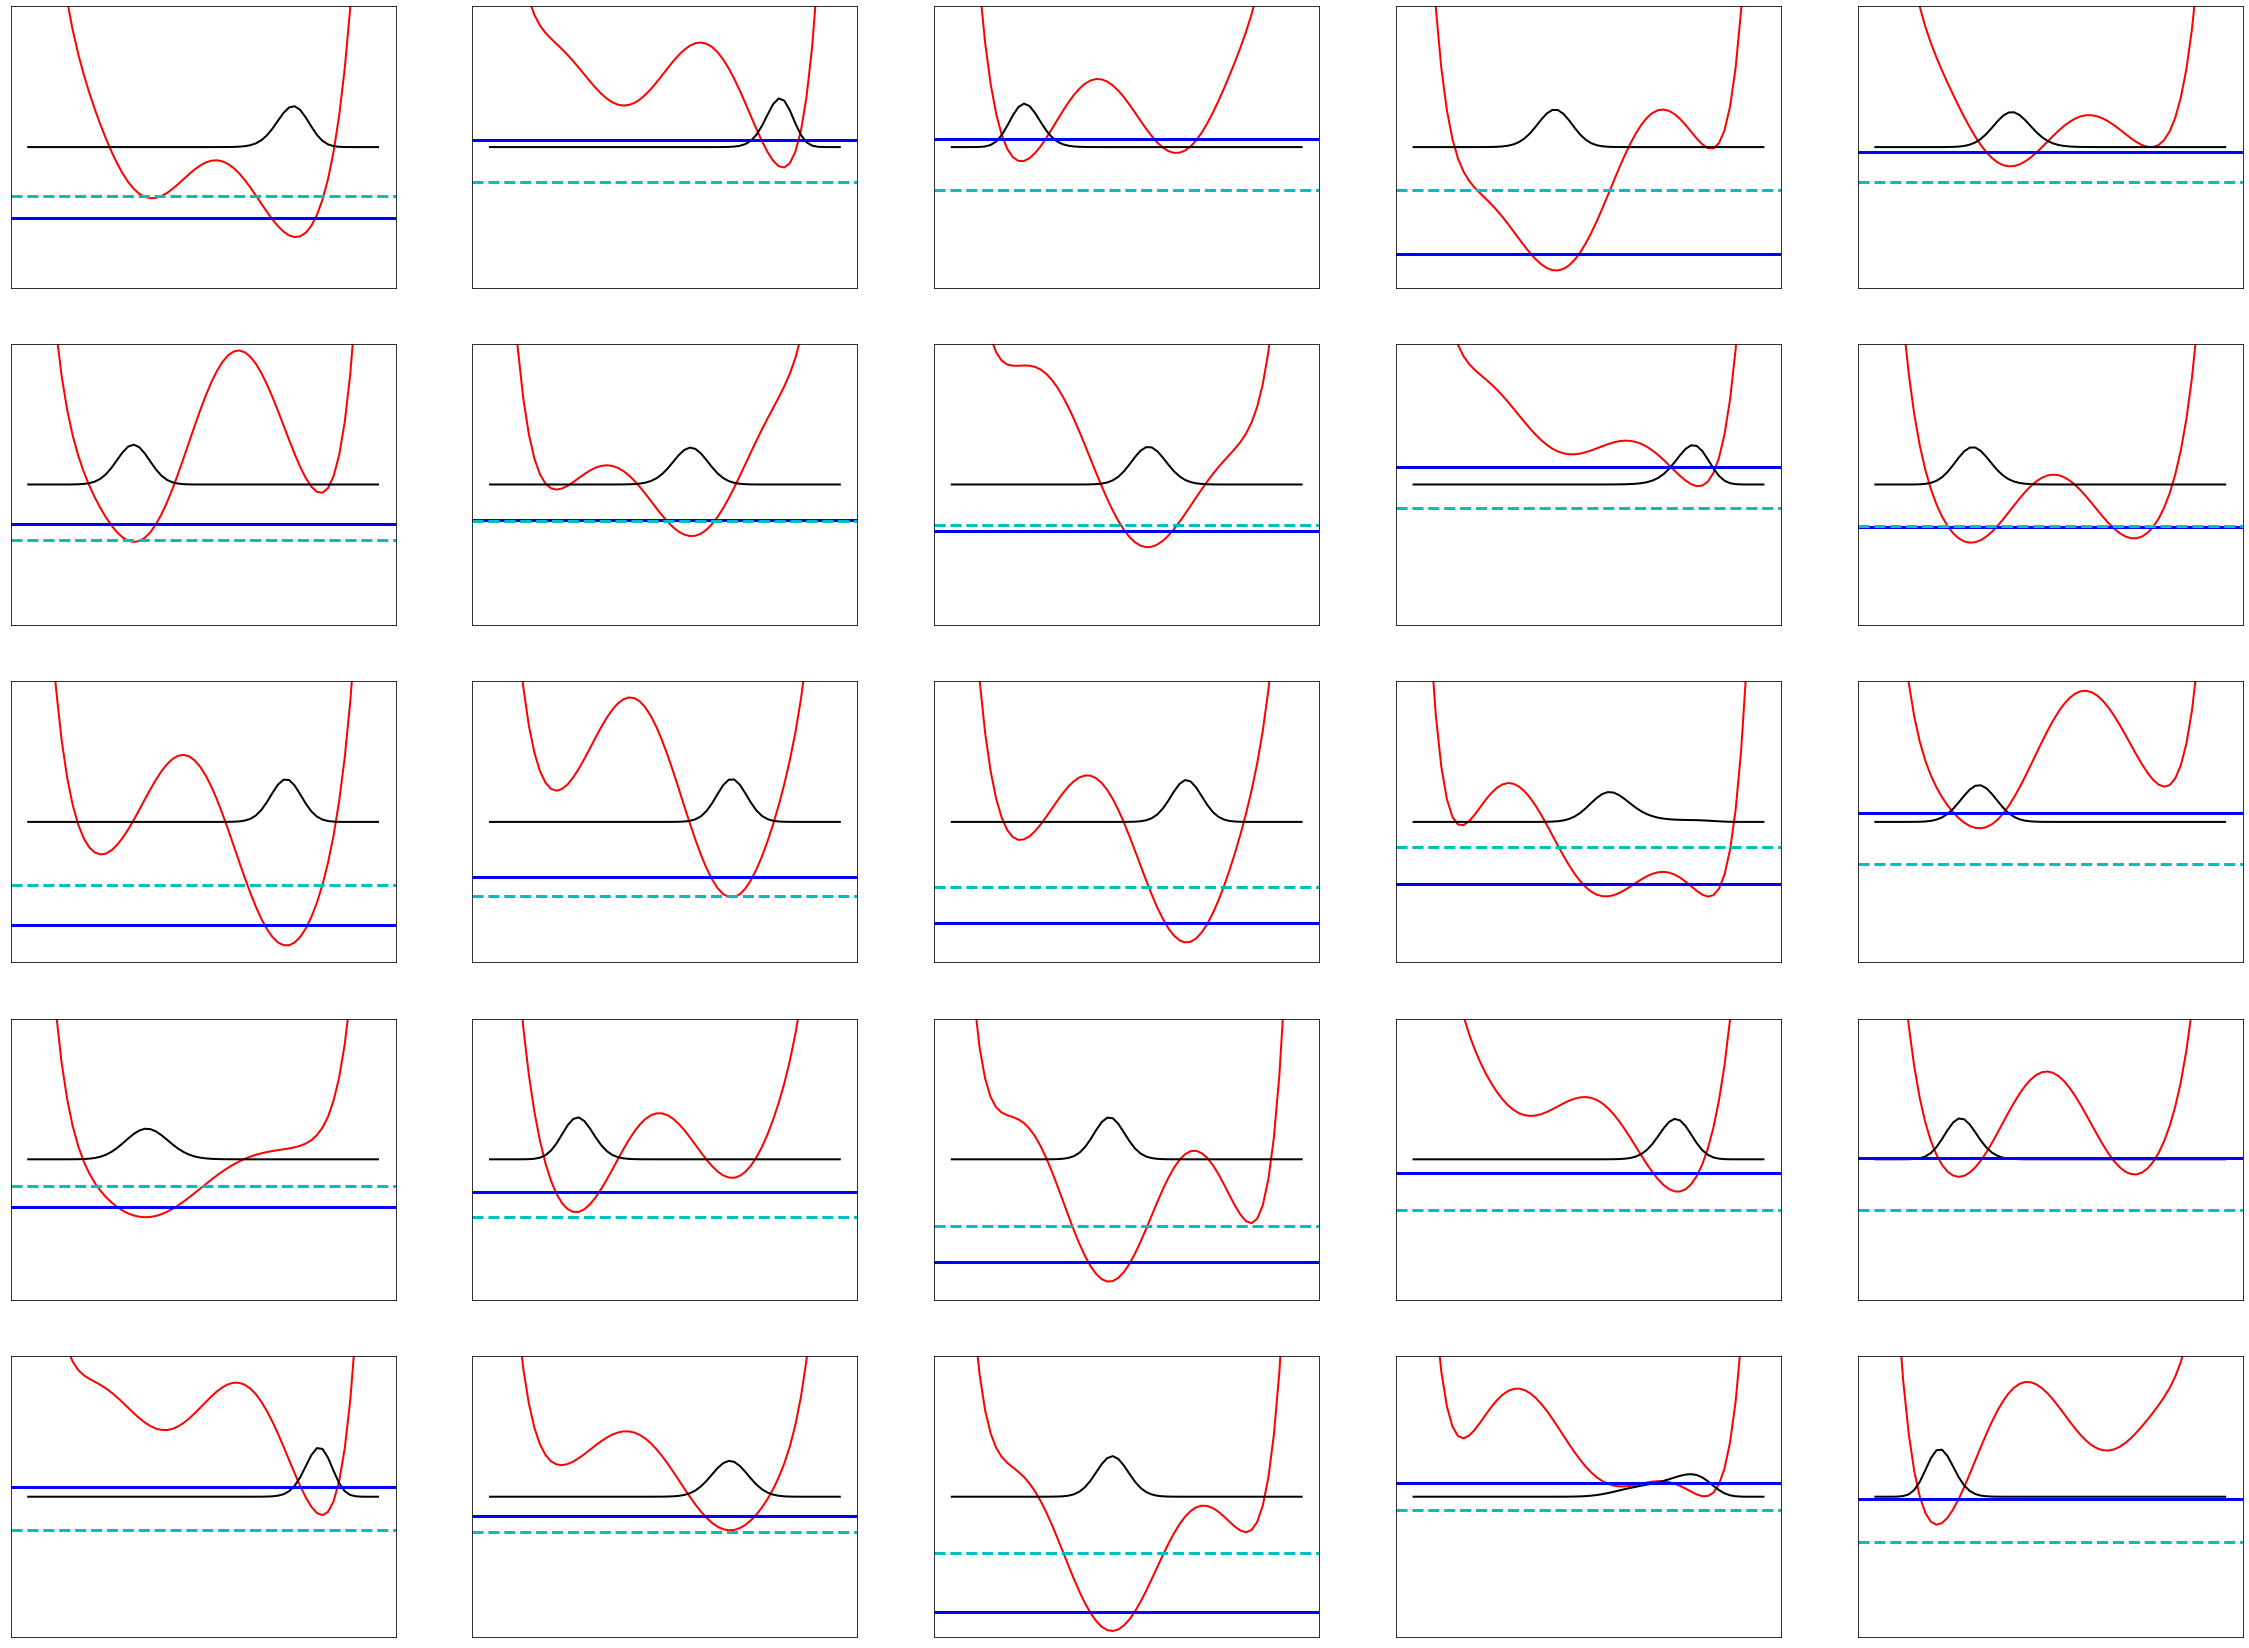

In [18]:
# Plot some results.
plt.rcParams['figure.figsize'] = [40, 30]
fig, axs = plt.subplots(5, 5)
k = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].plot(V_test[k, :, :].reshape(64,), 'r-', linewidth=2.0)
        axs[i, j].plot(n_test[k, :, :].reshape(64,), 'k-', linewidth=2.0)
        axs[i, j].axhline(E_test[k, 0], color='b', linewidth=3.0)
        axs[i, j].axhline(E_pred[k, 0], color='c', linestyle='--', linewidth=3.0)
        axs[i, j].set_ylim([-1,1])
        axs[i, j].set_yticklabels([])
        axs[i, j].set_xticklabels([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        k = k + 1
plt.savefig('n_predictions.pdf')